In [18]:
# Required imports
import torch
import torchtext
import pandas as pd
from sklearn.model_selection import train_test_split
import urllib

from gensim.parsing.preprocessing import preprocess_string, strip_punctuation

import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

## 1. Data importing and preprocessing

In [19]:
# Import raw data from CSV
mydata = pd.read_csv("./feed_data.csv")
mydata.head()

,Unnamed: 0,date_created,date_fetched,feed_source_id,id,image_link,link,rating,summary,title
0,0,2020-04-29 16:05:12+00:00,2020-04-29 17:52:15.645886+00:00,9,318,https://www.delo.si/images/slike/2020/04/29/o_...,https://www.delo.si/novice/slovenija/pocivalse...,0,"Konkretnih rešitev še ni, prvi pa naj bi na Hr...",Počivalšek in Cappelli o odpiranju hrvaške mej...
1,1,2020-04-29 13:53:40+00:00,2020-04-29 17:52:23.109152+00:00,18,328,http://www.arvio.si/wp-content/uploads/2020/03...,https://www.24ur.com/novice/korona/hrvaski-min...,0,Gospodarski minister Zdravko Počivalšek in hr...,Na Hrvaško naprej slovenski lastniki nepremičn...
2,2,2020-04-29 12:58:35+00:00,2020-04-29 17:52:14.902398+00:00,8,317,https://img.rtvslo.si/_up/upload/2020/04/29/65...,https://www.rtvslo.si/svet/azija-z-oceanijo/v-...,0,V južnokorejskem mestu Icheon je zagorelo na g...,V požaru v Južni Koreji umrlo najmanj 36 ljudi
3,3,2020-04-29 12:30:00+00:00,2020-04-29 17:52:21.202361+00:00,17,323,https://www.dnevnik.si/i/orig/2020/04/29/12352...,https://www.dnevnik.si/1042928232/kronika/v-ju...,0,Požar na gradbišču skladišča v južnokorejskem ...,V Južni Koreji več mrtvih v požaru na gradbišču
4,4,2020-04-29 10:02:00+00:00,2020-04-29 17:52:16.529798+00:00,10,319,https://siol.net//media/img/fd/36/facc0e367117...,https://siol.net/novice/slovenija/lastniki-nep...,0,Gospodarski minister Zdravko Počivalšek in hrv...,Lastniki nepremičnin na Hrvaškem maja že čez m...


In [20]:
# Set correct "text" and "target" columns.
# "text" is concatenated from article title and summary.
mydata["text"] = mydata["title"] + " " + mydata["summary"]
# If rating is positive, so is the "target" column
mydata["target"] = (mydata["rating"] >= 0).astype(int)

# Drop all unnecessary columns
mydata.drop(mydata.columns.difference(["text","target"]), 1, inplace=True)
mydata.head()

,text,target
0,Počivalšek in Cappelli o odpiranju hrvaške mej...,1
1,Na Hrvaško naprej slovenski lastniki nepremičn...,1
2,V požaru v Južni Koreji umrlo najmanj 36 ljudi...,1
3,V Južni Koreji več mrtvih v požaru na gradbišč...,1
4,Lastniki nepremičnin na Hrvaškem maja že čez m...,1


## 2. Prepare into Pytorch required form

### 2.1. Train and Validation split

In [21]:
# Split data into train and validation 
train_df, valid_df = train_test_split(mydata)
train_df.head()

,text,target
27,Vizjak napoveduje odvoz nakopičene embalaže na...,0
233,Prepoved premika čebelnjakov in čebeljih druži...,1
11,30. dopisna seja Vlade Republike Slovenije Vla...,1
181,"Pravila, kdaj je gradbeno dovoljenje nujno in ...",1
105,Izvajanje projekta lokacijske izboljšave zemlj...,1


### 2.2. Define Stopwords

In [22]:
# Taken from https://github.com/stopwords-iso/stopwords-sl/blob/master/stopwords-sl.json
stopwords = ["še", ".", "-", "2019", "28.3.2019", "(28.3.2019)", "–", "a","ali","april","avgust","b","bi","bil","bila","bile","bili","bilo","biti","blizu","bo","bodo","bojo","bolj","bom","bomo","boste","bova","boš","brez","c","cel","cela","celi","celo","d","da","daleč","dan","danes","datum","december","deset","deseta","deseti","deseto","devet","deveta","deveti","deveto","do","dober","dobra","dobri","dobro","dokler","dol","dolg","dolga","dolgi","dovolj","drug","druga","drugi","drugo","dva","dve","e","eden","en","ena","ene","eni","enkrat","eno","etc.","f","februar","g","g.","ga","ga.","gor","gospa","gospod","h","halo","i","idr.","ii","iii","in","iv","ix","iz","j","januar","jaz","je","ji","jih","jim","jo","julij","junij","jutri","k","kadarkoli","kaj","kajti","kako","kakor","kamor","kamorkoli","kar","karkoli","katerikoli","kdaj","kdo","kdorkoli","ker","ki","kje","kjer","kjerkoli","ko","koder","koderkoli","koga","komu","kot","kratek","kratka","kratke","kratki","l","lahka","lahke","lahki","lahko","le","lep","lepa","lepe","lepi","lepo","leto","m","maj","majhen","majhna","majhni","malce","malo","manj","marec","me","med","medtem","mene","mesec","mi","midva","midve","mnogo","moj","moja","moje","mora","morajo","moram","moramo","morate","moraš","morem","mu","n","na","nad","naj","najina","najino","najmanj","naju","največ","nam","narobe","nas","nato","nazaj","naš","naša","naše","ne","nedavno","nedelja","nek","neka","nekaj","nekatere","nekateri","nekatero","nekdo","neke","nekega","neki","nekje","neko","nekoga","nekoč","ni","nikamor","nikdar","nikjer","nikoli","nič","nje","njega","njegov","njegova","njegovo","njej","njemu","njen","njena","njeno","nji","njih","njihov","njihova","njihovo","njiju","njim","njo","njun","njuna","njuno","no","nocoj","november","npr.","o","ob","oba","obe","oboje","od","odprt","odprta","odprti","okoli","oktober","on","onadva","one","oni","onidve","osem","osma","osmi","osmo","oz.","p","pa","pet","peta","petek","peti","peto","po","pod","pogosto","poleg","poln","polna","polni","polno","ponavadi","ponedeljek","ponovno","potem","povsod","pozdravljen","pozdravljeni","prav","prava","prave","pravi","pravo","prazen","prazna","prazno","prbl.","precej","pred","prej","preko","pri","pribl.","približno","primer","pripravljen","pripravljena","pripravljeni","proti","prva","prvi","prvo","r","ravno","redko","res","reč","s","saj","sam","sama","same","sami","samo","se","sebe","sebi","sedaj","sedem","sedma","sedmi","sedmo","sem","september","seveda","si","sicer","skoraj","skozi","slab","smo","so","sobota","spet","sreda","srednja","srednji","sta","ste","stran","stvar","sva","t","ta","tak","taka","take","taki","tako","takoj","tam","te","tebe","tebi","tega","težak","težka","težki","težko","ti","tista","tiste","tisti","tisto","tj.","tja","to","toda","torek","tretja","tretje","tretji","tri","tu","tudi","tukaj","tvoj","tvoja","tvoje","u","v","vaju","vam","vas","vaš","vaša","vaše","ve","vedno","velik","velika","veliki","veliko","vendar","ves","več","vi","vidva","vii","viii","visok","visoka","visoke","visoki","vsa","vsaj","vsak","vsaka","vsakdo","vsake","vsaki","vsakomur","vse","vsega","vsi","vso","včasih","včeraj","x","z","za","zadaj","zadnji","zakaj","zaprta","zaprti","zaprto","zdaj","zelo","zunaj","č","če","često","četrta","četrtek","četrti","četrto","čez","čigav","š","šest","šesta","šesti","šesto","štiri","ž","že"]

### 2.3. Define the Tokenizer

In [23]:
def tokenize(text):
    """Tokenizes the provided text
    Args:
        text (str): The text to be tokenized
    Returns:
        list(tuple(str, int)): A list of (token, count) pairs from the text without the stopwords.
    """

    # Make everything lowercase
    custom_filters = [lambda x: x.lower()]
    tokens = preprocess_string(text, custom_filters)

    # Filter out all stopwords
    filtered_tokens = [w for w in tokens if not w in stopwords]

    # Return the filtered tokens
    return filtered_tokens

### 2.4. Define pyTorch fields and dataset

In [24]:
# The following will help make the results reproducible later.
SEED = 69
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [25]:
# Use the tokenizer we defined.
TEXT = torchtext.data.Field(tokenize=tokenize, include_lengths=True, batch_first=True)
# We preprocessed the labels to be integers, so use_vocab=False can be used.
LABEL = torchtext.data.LabelField(use_vocab=False, dtype=torch.float, batch_first=True)

In [26]:
# To use DataFrame as a Data source
# source : https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8

class DataFrameDataset(torchtext.data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(torchtext.data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)
    
    def __getitem__(self, idx):
        return super().__getitem__(idx)
    
    @staticmethod
    def sort_key(ex):
        return len(ex.text)

In [27]:
fields = [('text',TEXT), ('label',LABEL)]
train_ds = DataFrameDataset(train_df, fields)
valid_ds = DataFrameDataset(valid_df, fields)

# Both "train_ds" and "valid_ds" are of type "Dataset"
assert(isinstance(train_ds, torchtext.data.Dataset))
assert(isinstance(valid_ds, torchtext.data.Dataset))

In [28]:
# Lets look at a random example
print(vars(train_ds[15]))

# Check the type 
print(type(train_ds[15]))

{'text': ['izvajanje', 'določb', 'zakona', 'začasnih', 'ukrepih', 'zvezi', 'sodnimi,', 'upravnimi', 'drugimi', 'javnopravnimi', 'zadevami', 'dne', '29.3.2020', 'začel', 'veljati', 'zakon', 'začasnih', 'ukrepih', 'zvezi', 'sodnimi,', 'upravnimi', 'drugimi', 'javnopravnimi', 'zadevami', 'obvladovanje', 'širjenja', 'nalezljive', 'bolezni', 'sars-cov-2', '(covid-19)', '(zzusudjz),', 'ureja', 'poslovanje', 'upravnih', 'drugih', 'javnopravnih', 'zadevah,', 'katerih', 'upravni', 'organi', 'vodijo', 'upravne', 'druge', 'postopke.', 'geodetska', 'uprava', 'republike', 'slovenije', 'zato', 'ukrepe', 'zakona', 'uvedla', 'upravne', 'postopke', 'področja', 'evidentiranja', 'nepremičnin.'], 'label': 0}
<class 'torchtext.data.example.Example'>


In [29]:
# Import custom vectors for Slovenian.
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.sl.vec' 
urllib.request.urlretrieve(url, './wiki.sl.vec')
myvectors = torchtext.vocab.Vectors("./wiki.sl.vec")

In [30]:
# We will now build the vocabulary using only the training dataset.
# This can be accessed through TEXT.vocab and will be shared by the validation dataset.
TEXT.build_vocab(train_ds, vectors = myvectors)
LABEL.build_vocab(train_ds)

print("Size of TEXT vocabulary:",len(TEXT.vocab))
print("Size of LABEL vocabulary:",len(LABEL.vocab))

print("Most frequently used words:", TEXT.vocab.freqs.most_common(10)) 

Size of TEXT vocabulary: 4632
Size of LABEL vocabulary: 2
Most frequently used words: [('sir', 65), ('akutalne', 50), ('novice', 50), ('vrednosti', 38), ('dela', 35), ('ter', 30), ('slovenski', 30), ('1.', 27), ('nepremičnin', 26), ('zaradi', 25)]


### 2.5. Build the iterators

In [31]:
#set batch size
BATCH_SIZE = 10

#Load an iterator
train_iterator = torchtext.data.BucketIterator(
    train_ds, 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)


valid_iterator = torchtext.data.BucketIterator(
    valid_ds, 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

## 3. Implementing models

### 3.1. LSTM Model

In [32]:
class LSTM_net(torch.nn.Module):
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = torch.nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = torch.nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
      
        # Packed sequence
        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        dense_outputs=self.fc(hidden)

        # Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [46]:
# The next step would be to define the hyperparameters and instantiate the model.
size_of_vocab = len(TEXT.vocab)
embedding_dim = 300
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = LSTM_net(
    size_of_vocab,
    embedding_dim,
    num_hidden_nodes,
    num_output_nodes,
    num_layers,
    bidirectional = True,
    dropout = dropout)

##### Let us look at the model summary

In [47]:
print("Model architecture: ", model)

Model architecture:  LSTM_net(
  (embedding): Embedding(4632, 300)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)


In [48]:
print("Number of trainable parameters: ", utils.count_parameters(model))

Number of trainable parameters:  1500257


##### Initialize the embedding layer with the pretrained embeddings

In [49]:
#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.1793e-01, -5.3257e-01, -1.6364e-01,  ..., -2.7699e-01,
          5.0063e-01, -3.4038e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.2942e-01,  1.6698e-01,  1.8957e-01,  ..., -1.3900e-01,
         -1.2008e-01,  1.6834e-01],
        [ 2.3679e-01, -1.2987e-01,  8.4747e-02,  ..., -3.8223e-01,
          1.4442e-02,  5.0372e-04]])

### 3.2. Define Optimizer and Loss functions

In [50]:
# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
binary_accuracy = utils.binary_accuracy

# Push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

### 3.3. Define functions for training the model

In [51]:
def train_funct(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        #resets the gradients after every batch
        optimizer.zero_grad()
        #retrieve text and no. of words
        text, text_lengths = batch.text
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()
        #compute the loss
        loss = criterion(predictions, batch.label)
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        #backpropage the loss and compute the gradients
        loss.backward()
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_funct(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [52]:
N_EPOCHS = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train_funct(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    #evaluate the model
    valid_loss, valid_acc = evaluate_funct(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.630 | Train Acc: 71.20%
	 Val. Loss: 0.577 |  Val. Acc: 71.11%
	Train Loss: 0.539 | Train Acc: 71.20%
	 Val. Loss: 0.517 |  Val. Acc: 71.11%
	Train Loss: 0.355 | Train Acc: 80.80%
	 Val. Loss: 0.442 |  Val. Acc: 80.00%
	Train Loss: 0.143 | Train Acc: 97.60%
	 Val. Loss: 0.573 |  Val. Acc: 77.78%
	Train Loss: 0.081 | Train Acc: 97.60%
	 Val. Loss: 0.669 |  Val. Acc: 76.67%
	Train Loss: 0.072 | Train Acc: 97.20%
	 Val. Loss: 0.519 |  Val. Acc: 75.56%
	Train Loss: 0.044 | Train Acc: 98.80%
	 Val. Loss: 0.583 |  Val. Acc: 80.00%
	Train Loss: 0.033 | Train Acc: 98.80%
	 Val. Loss: 0.622 |  Val. Acc: 81.11%
	Train Loss: 0.037 | Train Acc: 98.00%
	 Val. Loss: 0.648 |  Val. Acc: 78.89%
	Train Loss: 0.028 | Train Acc: 98.80%
	 Val. Loss: 0.672 |  Val. Acc: 77.78%


### Plot train data

In [53]:
import matplotlib.pyplot as plt

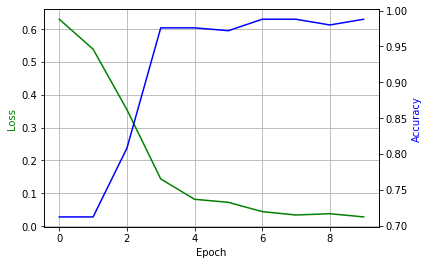

In [73]:
epochs = range(len(train_losses))

fig, ax1 = plt.subplots()
ax1.grid()
ax2 = ax1.twinx()
ax1.plot(epochs, train_losses, 'g-')
ax2.plot(epochs, train_accs, 'b-')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Accuracy', color='b')
# plt.savefig("here.png")
plt.show()